In [1]:
import os
import json
import time
import gzip
import bcolz
import numpy as np
import re
import copy
from multiprocessing import Pool
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt
import pickle
import random
import json
import inspect
from spacy.lang.en import English

In [2]:
params = {
    "seed" : 1337,
    "pickleFile" :  '../Datasets/Reviews/dataset.pkl',
    "gloveDimension" : 50,
    "glovePath" : "/media/data/Datasets/glove",
    "datasetReduction" : 16,
    "trainPortion" : 0.85,
    "valPortion" : 0.1,
    "vocabularyLimit" : 10000,
    "cutoff" : 60,
    "conditioning" : True,
    "datasetFile" : '../Datasets/Reviews/dataset_ready.pkl',
    "example_item_id" : 19, 
    "saveDataset" : True,
    "paramsJSONLocation" : '../Datasets/Reviews/dataset_parameters.json'
}

# params = {
#     "seed" : 1337,
#     "pickleFile" :  '../Datasets/Reviews/dataset.pkl',
#     "gloveDimension" : 50,
#     "glovePath" : "/media/data/Datasets/glove",
#     "datasetReduction" : 16,
#     "trainPortion" : 0.90,
#     "vocabularyLimit" : 30000,
#     "cutoff" : 60,
#     "conditioning" : False,
#     "datasetFile" : '../Datasets/Reviews/dataset_ready_no_condition.pkl',
#     "example_item_id" : 19, 
#     "saveDataset" : True,
#     "paramsJSONLocation" : 'dataset_parameters_no_condition.json'
# }

In [3]:
random.seed(params['seed'])
np.random.seed(params['seed'])

nlp = English()
sentencizer = nlp.create_pipe("sentencizer")
nlp.add_pipe(sentencizer)
tokenizer = nlp.create_pipe("tokenizer")

## Loading the Dataset

In [4]:
start = time.clock()
dataset = pickle.load( open( params['pickleFile'], "rb" ))
duration = time.clock() - start
print("Loaded the dataset in", round(duration,2), "seconds.")

Loaded the dataset in 6.91 seconds.


In [5]:
print("There are",len(dataset), "amazon items.")

There are 63001 amazon items.


## Loading Glove Words

In [6]:
def loadGlove(glove_path, dim=50):
    acceptedDimensions = [50, 100, 200, 300]
    if dim not in acceptedDimensions:
        print("You didn't choose a right dimension.")
        print("Try one of these:", acceptedDimensions)
        return None
    pickleWordFile = f'{glove_path}/6B.'+str(dim)+'_words.pkl'
    pickleIdFile   = f'{glove_path}/6B.'+str(dim)+'_idx.pkl'
    pickleDatFile  = f'{glove_path}/glove.6B.'+str(dim)+'.dat'
    pickleDataset  = f'{glove_path}/glove.6B.'+str(dim)+'d.txt'
    
    if os.path.isfile(pickleWordFile):
        # check if we've made the outputs before
        print("Preloading files..", end=" ")
        vectors = bcolz.open(pickleDatFile)[:]
        words = pickle.load(open(pickleWordFile, 'rb'))
        word2idx = pickle.load(open(pickleIdFile, 'rb'))
        glove = {w: vectors[word2idx[w]] for w in words}
        print("Done.")
        return glove
    else:
        print("Doesn't work.", end=" ")

glove = loadGlove(params['glovePath'], dim=params['gloveDimension'])
gloveWords = glove.keys()

Preloading files.. Done.


In [7]:
print("Glove Vocabulary Size:",len(gloveWords))

Glove Vocabulary Size: 400000


## Preprocessing Data

In [8]:
def preprocess(paragraph):
    # split paragraph by full stops
    paragraph = paragraph.lower()
    paragraph = re.sub("([,!?()-+&£$.%*'])", r' \1 ', paragraph)
    paragraph = re.sub('\s{2,}', ' ', paragraph)
    paragraph = paragraph.split(" ")
    # remove empty string
    return paragraph
    
def discretise(value, word):
    return word + "_" + str(value)

In [9]:
def handleItem(itemID, dataset=dataset, printDebug=False, condition=params['conditioning']):
    """
    Filters words out based on whether they're in the GloVe dataset or not.
    
    Parameters:
    
    """

    reviews = []
    for i in range(len(dataset[itemID])):
        # initialise variables
        entry = dataset[itemID][i]
        reviewerID = entry['reviewerID']
        
        if len(entry['reviewText']) < 1:
            continue

        """
        Review Text Processing
        """
        

        # spacy method
        sentences = [[str(i).lower() for i in tokenizer(str(sentence))] for sentence in nlp(entry['reviewText']).sents]
        
        # preprocess summary
        summary = [str(i).lower() for i in tokenizer(entry['summary'])]
        
        entries = [summary] + sentences
        entries = [x + ["<eos>"] for x in entries]
  
        # setup review parameters
        rating   = [discretise(entry['overall'], "rating")]

        # compute polarity
        good, bad = entry['helpful'][0], entry['helpful'][1]
        
        try:
            polarity = good/bad
            if polarity > 1:
                polarity = 1
            elif polarity < -1:
                polarity = -1
        except ZeroDivisionError:
            if good > bad:
                polarity = 1
            else:
                polarity = -1
        polarity = np.tanh(polarity)
        polarity = np.round(polarity, 1)
        polarity = [discretise(polarity, "polarity")]

        # create identity/conditioning entry
        identifier = itemID.lower()
        identity = [l for l in identifier] + rating + polarity

        # add conditionining entry to each entry
        formatted = [entry for entry in entries]

        if printDebug:
            print("ENTRY:",dataset[itemID][i])
            print("IDENTITY:",identity)

        for i in range(len(formatted)-1):
            # add the conditioning variable to the input. the output value does not have the conditioning variable.
            if condition:
                reviews.append([identity + formatted[i], formatted[i+1]])
            else:
                reviews.append([formatted[i], formatted[i+1]])
            if printDebug:
                print(reviews[-1][0], "->", reviews[-1][1])
        if printDebug:
            break
            
    return reviews

In [10]:
datasetKeys = list(dataset.keys())
example_set = handleItem(datasetKeys[params['example_item_id']],printDebug=True)

ENTRY: {'reviewerID': 'AA8JH8LD2H4P9', 'asin': '7214047977', 'reviewerName': 'Claudia J. Frier', 'helpful': [3, 4], 'reviewText': 'This fits my 7" kindle fire hd perfectly! I love it. It even has a slot for a stylus. The kindle is velcroed in so it\'s nice and secure. Very glad I bought this!', 'overall': 5.0, 'summary': 'love it', 'unixReviewTime': 1354665600, 'reviewTime': '12 5, 2012'}
IDENTITY: ['7', '2', '1', '4', '0', '4', '7', '9', '7', '7', 'rating_5.0', 'polarity_0.6']
['7', '2', '1', '4', '0', '4', '7', '9', '7', '7', 'rating_5.0', 'polarity_0.6', 'love', 'it', '<eos>'] -> ['this', 'fits', 'my', '7', '"', 'kindle', 'fire', 'hd', 'perfectly', '!', '<eos>']
['7', '2', '1', '4', '0', '4', '7', '9', '7', '7', 'rating_5.0', 'polarity_0.6', 'this', 'fits', 'my', '7', '"', 'kindle', 'fire', 'hd', 'perfectly', '!', '<eos>'] -> ['i', 'love', 'it', '.', '<eos>']
['7', '2', '1', '4', '0', '4', '7', '9', '7', '7', 'rating_5.0', 'polarity_0.6', 'i', 'love', 'it', '.', '<eos>'] -> ['it', '

In [11]:
example_set = handleItem(datasetKeys[25],printDebug=True)

ENTRY: {'reviewerID': 'A35U66IR43E4U6', 'asin': '9043413585', 'reviewerName': 'Amazon Customer', 'helpful': [1, 2], 'reviewText': 'I ordered this thing and received it,I tried for hours to get it to connect to my home wifi network but to no avail.A couple of months later I bought a smartphone and connected to my wifi network in seconds,dont buy this piece of junk.', 'overall': 1.0, 'summary': 'Piece of Junk', 'unixReviewTime': 1318809600, 'reviewTime': '10 17, 2011'}
IDENTITY: ['9', '0', '4', '3', '4', '1', '3', '5', '8', '5', 'rating_1.0', 'polarity_0.5']
['9', '0', '4', '3', '4', '1', '3', '5', '8', '5', 'rating_1.0', 'polarity_0.5', 'piece', 'of', 'junk', '<eos>'] -> ['i', 'ordered', 'this', 'thing', 'and', 'received', 'it', ',', 'i', 'tried', 'for', 'hours', 'to', 'get', 'it', 'to', 'connect', 'to', 'my', 'home', 'wifi', 'network', 'but', 'to', 'no', 'avail', '.', '<eos>']
['9', '0', '4', '3', '4', '1', '3', '5', '8', '5', 'rating_1.0', 'polarity_0.5', 'i', 'ordered', 'this', 'thin

In [12]:

identity = example_set[0][0][:example_set[0][0].index("<eos>")]

example_tag = {"reference":dataset[datasetKeys[params['example_item_id']]][0],
               "result":example_set}
# print(json.dumps(example_tag, indent=2, sort_keys=True))

In [13]:
print(len(datasetKeys))

63001


In [14]:
def processItems(func, args, n_processes = 7):
    p = Pool(n_processes)
    res_list = []
    with tqdm(total = len(args)) as pbar:
        for i, res in enumerate(p.imap_unordered(func, args)):
            pbar.update()
            res_list.append(res)
    pbar.close()
    p.close()
    p.join()
    return res_list

In [15]:
reviews = processItems(handleItem,datasetKeys[::params['datasetReduction']])

100%|██████████| 3938/3938 [00:47<00:00, 82.38it/s]


In [16]:
pols = {}
for r in reviews:
    for seq in r:
        polarity = seq[0][11]
        if polarity not in pols:
            pols[polarity] = 0
        pols[polarity] += 1
# print(pols)
for key in sorted(pols.keys()):
    print(key,"\t", pols[key])

polarity_-0.8 	 294843
polarity_0.0 	 32818
polarity_0.1 	 1882
polarity_0.2 	 4514
polarity_0.3 	 7278
polarity_0.4 	 5808
polarity_0.5 	 37145
polarity_0.6 	 42455
polarity_0.7 	 82582
polarity_0.8 	 218248


In [17]:
datasetSize = len(reviews)
trainRatio = int(datasetSize * params['trainPortion'])
valRatio = int(datasetSize * params['valPortion'])
train = reviews[:trainRatio]
validation = reviews[trainRatio:trainRatio+valRatio]
test = reviews[trainRatio+valRatio:]

print("Num Reviews:")
print("Training:", len(train), "\t\tValidation:",len(validation), "\tTest:",len(test))

# now we need to flatten train and validation.
trainents = []
for review in train:
    trainents += [entry for entry in review]
valents = []
for review in validation:
    valents += [entry for entry in review]
testents = []
for review in test:
    testents += [entry for entry in review]
    
train = trainents
validation = valents
test = testents

print("Sequences:")
print("Training:",len(train),"\tValidation:",len(validation), "\tTest:",len(test))

Num Reviews:
Training: 3347 		Validation: 393 	Test: 198
Sequences:
Training: 619718 	Validation: 64913 	Test: 42942


In [18]:
# get the number of itemIDs
for row in train:
    print(row)
    break

[['b', '0', '0', '0', '0', '0', 'j', '1', 'u', 'b', 'rating_5.0', 'polarity_-0.8', 'kb', 'at', 'to', 'ps/2', 'adapter', '<eos>'], ['the', 'package', 'arrived', 'in', 'a', 'timely', 'fashion', 'and', 'in', 'good', 'shape', '.', '<eos>']]


## Getting ID's of words

To improve the throughput of the model, we should reduce the embedding size. Here we'll look at all the words and keep track ones that exist. We'll make a reduced word2id based on this set.

In [19]:
wordcounts = {}

In [20]:
# here we reduce the size of the dataset so we can debug our model.
print("Subsetting Reviews..")
print("We now have", len(train), "reviews.")

Subsetting Reviews..
We now have 619718 reviews.


In [21]:
# get word frequency for words in training data
for row in tqdm(train):
    for sequences in row:
        for word in sequences:
            word = str(word)
            # setup container if word does not exist
            if word not in wordcounts:
                wordcounts[word] = 0
            # increment
            wordcounts[word] += 1

100%|██████████| 619718/619718 [00:10<00:00, 58059.60it/s]


In [22]:
# get words that are not in the glove dataset
knowns   = [word for word in wordcounts if word in glove]
unknowns = [word for word in wordcounts if word not in glove]
# sort words by their frequency
wordOrder = list(sorted(knowns, key=lambda x: wordcounts[x], reverse=True))

In [23]:
print(len(knowns), len(unknowns))

42914 91235


In [24]:
# threshold number of tokens based on the vocabulary limit.
wordOrder = wordOrder[:params['vocabularyLimit']]

In [25]:
# store glove vectors for each token
weights = [glove[word] for word in wordOrder]

In [26]:
# create vectors for rating and polarity
for word in unknowns:
    if ("rating" in word) or ("polarity" in word):
        try:
            part = word.split("_")
            if part[1] == "-0.0":
                part[1] = "0.0"
            weight = glove[part[0]] + glove[part[1]]
            wordOrder.append(word)
            weights.append(weight)
        except:
            pass

In [27]:
# create dictionaries for constant time referencing
id2word = {idx: w for (idx, w) in enumerate(wordOrder)}
word2id = {w: idx for (idx, w) in enumerate(wordOrder)}

In [28]:
lim = len(word2id)

# add <sos> (start of sequence)
weights.append(glove['sos'])
word2id['<sos>'] = lim
id2word[lim] = ['<sos>']
lim += 1

# add <eos> (end of sequence)
weights.append(glove['eos'])
word2id['<eos>'] = lim
id2word[lim] = '<eos>'
lim += 1


gloveDimension = params['gloveDimension']

sorWeight = np.random.normal(0,0.5,gloveDimension)
weights.append(sorWeight)
word2id['<summary>'] = lim
id2word[lim] = '<summary>'
lim += 1

sorWeight = np.random.normal(0,0.5,gloveDimension)
weights.append(sorWeight)
word2id['</summary>'] = lim
id2word[lim] = '</summary>'
lim += 1

sorWeight = np.random.normal(0,0.5,gloveDimension)
weights.append(sorWeight)
word2id['<text>'] = lim
id2word[lim] = '<text>'
lim += 1

sorWeight = np.random.normal(0,0.5,gloveDimension)
weights.append(sorWeight)
word2id['</text>'] = lim
id2word[lim] = '</text>'
lim += 1


# add <unk> (unknown token)
weights.append(glove['unk'])
word2id['<unk>'] = lim
id2word[lim] = '<unk>'

# add <pad> 
id2word[len(word2id)] = "<pad>"
word2id["<pad>"] = len(word2id)
weights.append(np.random.normal(0,0,gloveDimension))

In [29]:
# create functions that incorporate dictionary search
# and returns <unk> token upon failure
def wordToID(word,corp=word2id):
    if word in corp:
        return corp[word]
    return corp['<unk>']

def IDToWord(id,corp=id2word, ref=word2id):
    if id in corp:
        return corp[id]
    return corp[ref['<unk>']]

In [30]:
# convert words to their id's in the review.
def entriesToWordIDs(group):
    return [[[wordToID(word) for word in seq] for seq in row] for row in tqdm(group)]
    
train = entriesToWordIDs(train)
validation = entriesToWordIDs(validation)
test = entriesToWordIDs(test)

100%|██████████| 42942/42942 [00:00<00:00, 105621.50it/s]


100%|██████████| 42942/42942 [00:00<00:00, 489230.84it/s]


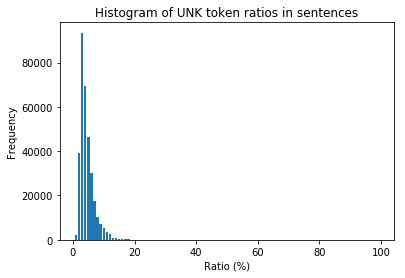

In [31]:
unk_ratios = {}
for batch in [train, validation,test]:
    for seq in tqdm(batch):
        ratio = seq[0].count(wordToID('<unk>'))/len(seq[0])
        ratio = round(ratio,2)
        if ratio not in unk_ratios:
            unk_ratios[ratio] = 0
        unk_ratios[ratio] += 1
ratio_x = [i/100 for i in range(0, 100, 1)]
ratio_y = [unk_ratios[i] if i in unk_ratios else 0.0 for i in ratio_x]
ratio_x = [round(i * 100,0) for i in ratio_x]

plt.bar(ratio_x[1:],ratio_y[1:])
plt.title("Histogram of UNK token ratios in sentences")
plt.xlabel("Ratio (%)")
plt.ylabel("Frequency")
plt.show()

In [32]:
def getLongestSeq(dataset,datatype="train"):
    index = 0 if datatype is "train" else 1
    sizes = {}
    for i in range(len(dataset)):
        row = dataset[i][index]
        length = len(row)
        if length not in sizes:
            sizes[length] = []
        sizes[length].append(i)

    seqlengths = list(sorted(sizes.keys(), key=lambda x: len(sizes[x]), reverse=True))
    print("The longest sequence in our "+datatype+" dataset is",max(seqlengths),"tokens long:")
    
    seq_longest_id = sizes[max(seqlengths)][0]

    print(" ".join([IDToWord(x) for x in dataset[seq_longest_id][index]]))
    
    # used for charting purposes
    for i in range(1709):
        if i not in sizes:
            sizes[i] = []
            
    # plot histogram of sequence lengths
    ents = [x for x in range(0,80)]
    bins = [len(sizes[x]) for x in ents]
    plt.bar(ents,bins)
    plt.show()

The longest sequence in our train dataset is 1631 tokens long:
b 0 0 8 p o 5 c s i rating_1.0 polarity_0.5 file <unk> size set to 17 * record <unk> <unk> random <unk> <unk> <unk> record <unk> <unk> <unk> <unk> <unk> write <unk> <unk> read <unk> <unk> <unk> read <unk> write <unk> read <unk> <unk> <unk> read <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> 4 <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> 8 <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> 16 <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> 32 <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk

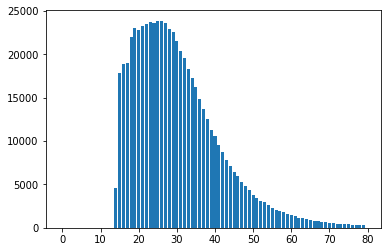

In [33]:
getLongestSeq(train,datatype="train")

The longest sequence in our validation dataset is 550 tokens long:
test file created on saturday , april 06 , 2013 at <unk> volume name : <unk> <unk> volume type : <unk> <unk> volume size : <unk> <unk> volume free space : <unk> <unk> disk cache effects : <unk> reads and writes performed <unk> test results : test cycles : <unk> size <unk> sequential read <unk> sequential write <unk> random read <unk> random <unk> <unk> <unk> <unk> mb / sec <unk> <unk> mb / sec <unk> <unk> mb / sec <unk> <unk> mb / <unk> <unk> <unk> <unk> mb / sec <unk> <unk> mb / sec <unk> <unk> mb / sec <unk> <unk> mb / <unk> <unk> <unk> <unk> mb / sec <unk> <unk> mb / sec <unk> <unk> mb / sec <unk> <unk> mb / <unk> <unk> <unk> <unk> mb / sec <unk> <unk> mb / sec <unk> <unk> mb / sec <unk> <unk> mb / <unk> <unk> <unk> <unk> mb / sec <unk> <unk> mb / sec <unk> <unk> mb / sec <unk> <unk> mb / <unk> <unk> <unk> <unk> mb / sec <unk> <unk> mb / sec <unk> <unk> mb / sec <unk> <unk> mb / <unk> <unk> <unk> <unk> mb / sec <unk>

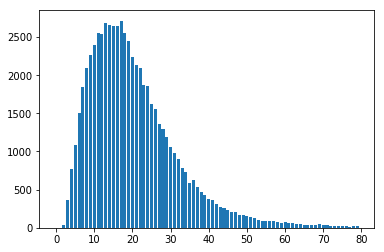

In [34]:
getLongestSeq(validation,datatype="validation")

In [35]:
print("Cutoff sequence length:", params['cutoff'])

Cutoff sequence length: 60


In [36]:
def trimSeq(group, cutoff):
    good = []
    for i in tqdm(range(len(group))):
        row = group[i]
        # keep sequences where the input and output are both shorter
        # in length compared to cutoff.
        if len(row[0]) <= cutoff and len(row[1]) <= cutoff:
            good.append(i) 
    group = [group[x] for x in good]
    return group

print("Trimming Sequences..")
print("BEFORE:", len(train), len(validation), len(test))
train = trimSeq(train, params['cutoff'])
validation = trimSeq(validation, params['cutoff'])
test = trimSeq(test, params['cutoff'])
print("AFTER:", len(train), len(validation), len(test))

 43%|████▎     | 265257/619718 [00:00<00:00, 2652559.88it/s]

Trimming Sequences..
BEFORE: 619718 64913 42942


100%|██████████| 42942/42942 [00:00<00:00, 2470940.60it/s]

AFTER: 594131 61859 40822


In [37]:
# remove sequences where unk comprises of at least 20% of the sequence.
def removeUnkSeqs(group, unkID=word2id['<unk>'], threshold=0.1):
    good = []
    for i in tqdm(range(len(group))):
        row = group[i]
        # keep sequences where the input and output are both shorter
        # in length compared to cutoff.
        inp_prob = row[0].count(unkID)/len(row[0])
        out_prob = row[1].count(unkID)/len(row[1])
        if inp_prob <= threshold and out_prob <= threshold:
            good.append(i) 
    group = [group[x] for x in good]
    return group

print("Removing sequences with high UNK token counts..")
print("BEFORE:", len(train), len(validation), len(test))
train = removeUnkSeqs(train)
validation = removeUnkSeqs(validation)
test = removeUnkSeqs(test)
print("AFTER:", len(train), len(validation), len(test))

 29%|██▉       | 173673/594131 [00:00<00:00, 860310.32it/s]

Removing sequences with high UNK token counts..
BEFORE: 594131 61859 40822


100%|██████████| 40822/40822 [00:00<00:00, 868862.99it/s]

AFTER: 522718 54291 35782


In [38]:
# create container ready for use in dataset
# we do not add padding here as we want to reduce storage size!
container = {
    'id2word' : id2word,
    'word2id' : word2id,
    'train' : train,
    'validation': validation,
    'test': test,
    'weights' : np.matrix(weights),
    'cutoff' : params['cutoff']
}

In [39]:
def convert_bytes(num):
    """
    this function will convert bytes to MB.... GB... etc
    """
    for x in ['bytes', 'KB', 'MB', 'GB', 'TB']:
        if num < 1024.0:
            return "%3.1f %s" % (num, x)
        num /= 1024.0

if params['saveDataset']:
    # save the dataset to a pickle file.
    output = open(params['datasetFile'], 'wb')
    pickle.dump(container, output)
    output.close()

    # save dataset preprocessing parameters
    params['example_filtering'] = example_tag
    params['handleItem'] = inspect.getsource(handleItem)
    with open(params['paramsJSONLocation'], 'w') as outfile:
        json.dump(params, outfile)

    print("Saved!", convert_bytes(os.stat(params['datasetFile']).st_size))
    print("Save location:", params['datasetFile'])
    print("dataset parameters save location:", params['paramsJSONLocation'])

Saved! 85.2 MB
Save location: ../Datasets/Reviews/dataset_ready.pkl
dataset parameters save location: ../Datasets/Reviews/dataset_parameters.json
